This feature selection notebook does a filter followed by a wrapper for a binary dependent variable (binary classification). It's capable of doing the filter on more than one file. The variable files are called vars1.csv, vars2.csv ... Or you can make the input file name(s) anything you want.

The filter runs separately on each vars file and keeps the top num_filter variables from each file. If there are more than one vars files we'll again select the top num_filter variables across all the vars.csv files.

If balance = 0 the entire files are used. If balance != 0 then balance is the RATIO OF BADS TO GOODS retained for the rest of the feature selection. We keep all the rare class (bads) and downsample the goods. I think in general it's better to keep balance = 0.

I've got an annoying warning message from the wrapper and I can't figure out how to get rid of it. If anybody figures this out please send a message to stevecoggeshall@gmail.com

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import datetime as dt
import gc
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from lightgbm import LGBMClassifier
%matplotlib inline
start_time = dt.datetime.now()

In [6]:
# set some parameters
num_files = 1
# I recommend set num_filter to be about 10 to 20% of the original # variables
num_filter = 400
# I recommend set num_wrapper to be about 50, then look for a saturation of the model performance as variables are added
# Then you can run it again with num_wrapper just a bit above this saturation point, not more than about twice this saturation number
num_wrapper = 20
balance = 0
detect_rate = .03
index_name = 'Recnum'
y_name = 'Fraud'
good_label = 0
bad_label = 1

## Run a filter on all the files

In [3]:
%%time
filter_score_df_list = []
for i in range(num_files):
#     file_name = "vars"+str(i+1)+'.csv'
    file_name = 'New folder/candidate_variables.csv'
    df = pd.read_csv(file_name)
    print("********** working on",file_name,"size is",df.shape)
    df = df.set_index(index_name) 
#    df = df[df.index <= 84300] # remove the last two months as the out-of-time data (OOT)
    df = df[df.index >= 2995] # remove the first 2 weeks of records since their variables aren't well formed
    df['RANDOM'] = np.random.ranf(len(df)) # add a random number variable to make sure it doesn't come up as important
    goods = df[df[y_name] == good_label]
    bads = df[df[y_name] == bad_label]
    del df # don't need this file anymore
    num_goods = len(goods)
    num_bads = len(bads)
    num_vars = len(bads.columns)-2
    if(balance != 0):
        if(i == 0):
            num_goods_desired = int(min(num_goods,num_bads*balance))
            goods = goods.sample(n=num_goods_desired,random_state=1)
            goods_keep = list(goods.index)
            goods_keep.sort()
    
        if(i > 0):
            goods = goods.loc[goods_keep] 
            
    df_sampled = pd.concat([goods,bads])
    df_sampled.sort_index(inplace=True)
    filter_score = pd.DataFrame(np.zeros((num_vars+1,2)))
    filter_score.columns = ['variable','filter score']   
    j = 0
    for column in df_sampled:
        filter_score.loc[j,'variable'] = column
        filter_score.loc[j,'filter score'] = sps.ks_2samp(goods[column],bads[column])[0]
        j = j+1
        if j%100 == 0:
            print(j)

    filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
    vars_keep = list(filter_score['variable'][1:num_filter+1]) 
    print(file_name,filter_score.head(20))
    if(i == 0): # if first time through need to initialize some stuff
        Y = pd.DataFrame(df_sampled[y_name], index=df_sampled.index)
        df_top = df_sampled.filter(vars_keep, axis=1)
            
    if(i > 0): # if more than one variable file we use this loop
        data_new_top = df_sampled.filter(vars_keep, axis=1)
        df_top = pd.concat([df_top,data_new_top], axis=1)

    filter_score_df_list.append(filter_score)
    
    del goods # delete these before starting the next file, if any
    del bads
    gc.collect()
filter_score = pd.concat(filter_score_df_list)

********** working on New folder/candidate_variables.csv size is (96397, 2344)
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
New folder/candidate_variables.csv                       variable  filter score
0                        Fraud      1.000000
612          card_zip3_total_7      0.676549
228           card_zip_total_7      0.666816
603          card_zip3_total_3      0.660260
621         card_zip3_total_14      0.659257
292         card_state_total_7      0.654135
237          card_zip_total_14      0.652244
219           card_zip_total_3      0.652217
283         card_state_total_3      0.644602
301        card_state_total_14      0.641512
164         card_merch_total_7      0.637702
246          card_zip_total_30      0.637171
868  Card_Merchnum_Zip_total_7      0.635141
610            card_zip3_max_7      0.630957
155         card_merch_total_3      0.630782
630         card_zip3_total_30      0.630295
173        card

<timed exec>:40: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.


CPU times: user 37.6 s, sys: 4.74 s, total: 42.4 s
Wall time: 46.6 s


In [4]:
filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
filter_score.reset_index(drop=True,inplace=True)

In [5]:
filter_score.head(30)

,variable,filter score
0,Fraud,1.000000
1,card_zip3_total_7,0.676549
2,card_zip_total_7,0.666816
3,card_zip3_total_3,0.660260
4,card_zip3_total_14,0.659257
5,card_state_total_7,0.654135
6,card_zip_total_14,0.652244
7,card_zip_total_3,0.652217
8,card_state_total_3,0.644602
9,card_state_total_14,0.641512


In [6]:
filter_score.tail(10)

,variable,filter score
2334,Card_Merchnum_desc_unique_count_for_card_state_14,0.000065
2335,Card_Merchnum_desc_unique_count_for_card_state_7,0.000043
2336,Card_Merchnum_Zip_unique_count_for_card_state_30,0.000032
2337,Card_Merchdesc_Zip_unique_count_for_card_state_7,0.000032
2338,Card_Merchnum_desc_unique_count_for_card_state_3,0.000022
2339,merch_zip_unique_count_for_merch_state_7,0.000022
2340,Card_Merchdesc_Zip_unique_count_for_card_state_1,0.000022
2341,card_zip3_unique_count_for_card_state_1,0.000017
2342,card_merch_unique_count_for_card_state_1,0.000011
2343,card_merch_unique_count_for_Cardnum_1,0.000000


In [7]:
filter_score.shape

(2344, 2)

In [8]:
filter_score.head(80).to_csv('filter_top.csv')
vars_keep = list(filter_score['variable'][num_files:num_filter+3])
print(i,' vars_keep:',vars_keep)

0  vars_keep: ['card_zip3_total_7', 'card_zip_total_7', 'card_zip3_total_3', 'card_zip3_total_14', 'card_state_total_7', 'card_zip_total_14', 'card_zip_total_3', 'card_state_total_3', 'card_state_total_14', 'card_merch_total_7', 'card_zip_total_30', 'Card_Merchnum_Zip_total_7', 'card_zip3_max_7', 'card_merch_total_3', 'card_zip3_total_30', 'card_merch_total_14', 'card_zip3_max_14', 'Card_Merchnum_Zip_total_3', 'card_zip_max_14', 'Card_Merchnum_Zip_total_14', 'card_zip_max_7', 'card_zip_max_30', 'Card_Merchdesc_total_7', 'Card_Merchdesc_Zip_total_7', 'card_zip_total_60', 'Card_Merchnum_desc_total_7', 'card_zip3_total_1', 'card_merch_total_30', 'card_zip3_max_30', 'Card_Merchdesc_total_14', 'Card_Merchnum_Zip_total_30', 'Card_Merchnum_desc_total_14', 'Card_Merchdesc_Zip_total_14', 'card_zip3_total_60', 'card_zip_total_1', 'Card_Merchdesc_total_3', 'card_state_max_7', 'card_state_total_1', 'Card_Merchdesc_Zip_total_3', 'Card_Merchnum_desc_total_3', 'Card_Merchdesc_total_30', 'card_zip3_ma

In [9]:
vars_keep_df = pd.DataFrame({'col':vars_keep})
vars_keep_df.to_csv('vars_keep_filter.csv',index=False)
df_keep = df_top.filter(vars_keep, axis=1)
df_keep.head()

,card_zip3_total_7,card_zip_total_7,card_zip3_total_3,card_zip3_total_14,card_state_total_7,card_zip_total_14,card_zip_total_3,card_state_total_3,card_state_total_14,card_merch_total_7,...,zip3_max_3,zip3_actual/max_30,state_des_max_60,zip3_actual/med_14,merch_zip_total_30,Merchnum_desc_avg_30,card_zip3_count_7,state_des_avg_30,card_zip3_variability_max_3,Merchnum_variability_med_30
Recnum,,,,,,,,,,,,,,,,,,,,,
2995,1023.04,1023.04,174.20,1023.04,1023.04,1023.04,174.20,174.20,1023.04,1023.04,...,2454.99,0.070958,2454.99,1.360937,9711.43,262.471081,3,262.471081,0.0,-46.20
2996,250.00,250.00,250.00,250.00,250.00,250.00,250.00,250.00,250.00,250.00,...,2370.00,0.105485,250.00,1.917031,530.00,176.666667,1,176.666667,0.0,-40.00
2997,76.85,76.85,76.85,76.85,76.85,76.85,76.85,76.85,76.85,76.85,...,1097.60,0.049089,1097.60,1.000000,4106.55,241.561765,2,241.561765,0.0,0.00
2998,1269.00,1269.00,1269.00,1269.00,1269.00,1269.00,1269.00,1269.00,1269.00,1269.00,...,2237.00,0.271967,4666.00,4.565569,26728.80,921.682759,1,886.482727,0.0,-991.05
2999,288.38,288.38,288.38,288.38,288.38,288.38,288.38,288.38,288.38,288.38,...,1818.10,0.119759,756.08,0.915492,2670.60,445.100000,1,445.100000,0.0,89.61


In [10]:
df_keep.shape

(93409, 400)

In [11]:
Y.head()

,Fraud
Recnum,
2995,0
2996,0
2997,0
2998,0
2999,0


In [12]:
Y = Y.values
Y_save = Y.copy()

In [13]:
# Y = np.array(Y)
X = df_keep
print(Y)

[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [14]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 0:00:46.782517


In [15]:
print(X.shape,Y.shape)

(93409, 400) (93409, 1)


In [16]:
print(type(X),type(Y))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


In [17]:
# I'd like to define a scoring for the wrapper that's KS, but I haven't gotten around to this yet.
# def KSscore(classifier, x,y)
#     goods = 

In [18]:
def fdr(classifier, x, y, cutoff=detect_rate):
# Calculates FDR score for the given classifier on dataset x and y with cutoff value
# get the probability list from the given classifier
    return fdr_prob(y, classifier.predict_proba(x), cutoff)
def fdr_prob(y, y_prob, cutoff=detect_rate):
    if len(y_prob.shape) != 1:    # sometimes the proba list can contain many columns, one for each category
        y_prob = y_prob[:, -1:]   # only the last one (fraud_label==1) is used here.
    num_fraud = len(y[y == 1])    # count the total nunber of frauds   
# sort the proba list from high to low while retain the true (not predicted) fraud label
    sorted_prob = np.asarray(sorted(zip(y_prob, y), key=lambda x: x[0], reverse=True))
    cutoff_bin = sorted_prob[0:int(len(y) * cutoff), 1:]  # 3% cutoff
# return the FDR score (#fraud_in_cutoff / #total_fraud)
    return len(cutoff_bin[cutoff_bin == 1]) / num_fraud   

## Run a wrapper on the remaining top variables

In [19]:
%%time
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning) 
# If you're doing forward selection it's enough to stop at num_wrapper variables. 
# If you're doing backward selection you need to go through all the variables to get a sorted list of num_wrapper variables.

# I can't figure out how to get rid of this annoying warning! I don't know what I'm doing wrong...

nfeatures = len(X.columns)
# clf = RandomForestClassifier(n_estimators=5) # simple, fast nonlinear model for the wrapper
clf = LGBMClassifier(n_estimators=40,num_leaves=4) # simple, fast nonlinear model for the wrapper
sfs = SFS(clf,k_features=num_wrapper,forward=True,verbose=0,scoring=fdr,cv=4,n_jobs=-1) # use for forward selection
# sfs = SFS(clf,k_features=1,forward=False,verbose=0,scoring=fdr,cv=4,n_jobs=-1) # use for backward selection
sfs.fit(X,Y)

CPU times: user 39.2 s, sys: 7.59 s, total: 46.8 s
Wall time: 23min 2s


SequentialFeatureSelector(cv=4,
                          estimator=LGBMClassifier(n_estimators=40,
                                                   num_leaves=4),
                          k_features=(20, 20), n_jobs=-1,
                          scoring=<function fdr at 0x7f6bacf7e320>)

In [20]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 0:23:48.977952


In [21]:
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("muted")

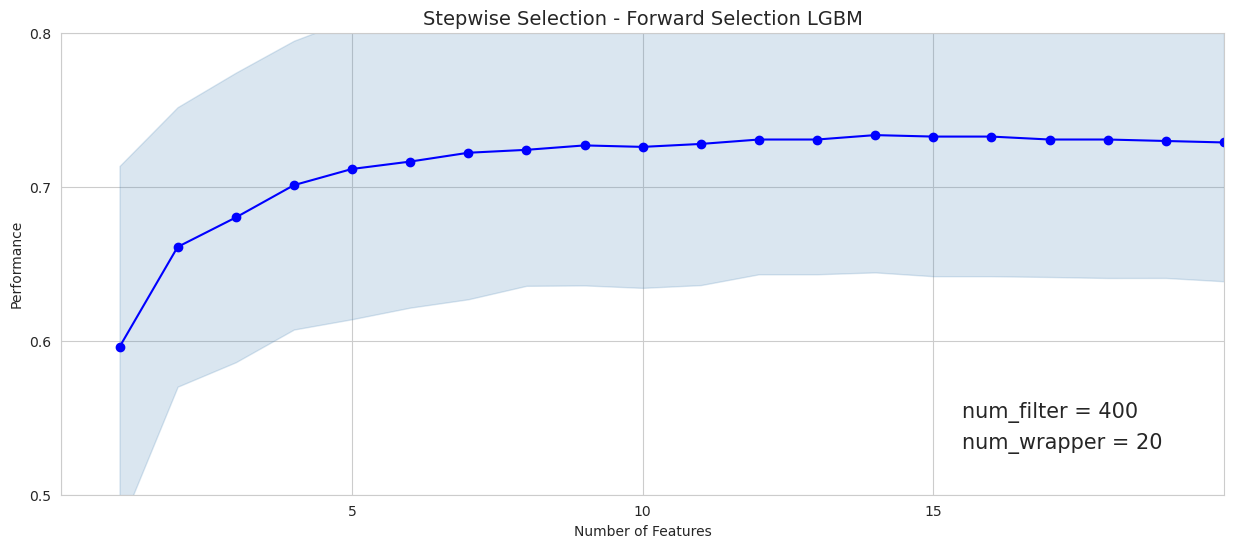

In [25]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev', figsize=(15, 6))
# plt.xticks(np.arange(0, len(X.columns), step=5))
plt.xticks(np.arange(0, num_wrapper, step=5))
plt.yticks(np.arange(0,1,step=.1))
plt.ylim([.5, .8])
plt.xlim(0,num_wrapper)
plt.title('Stepwise Selection - Forward Selection LGBM', fontsize = 14)
plt.text(15.5, 0.55, f'num_filter = {num_filter}', fontsize = 15)
plt.text(15.5, 0.53, f'num_wrapper = {num_wrapper}', fontsize = 15)
plt.savefig(f'performance_nvars_back{num_filter}.png')
plt.show()

In [26]:
vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

In [27]:
ordered_vars_FS = vars_FS.copy()
for i in range(len(ordered_vars_FS)):
    ordered_vars_FS.loc[i+1,'add variables in this order'] = int(i+1)
    if i+1 == 1:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(ordered_vars_FS.loc[i+1,'feature_names'])[0])
    else:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(set(ordered_vars_FS.loc[i+1,'feature_names']) - set(ordered_vars_FS.loc[i,'feature_names'])))[0]
# You might also need this following line. It converts a list to a string
#         ordered_vars_FS.loc[i+1,'variable name'] = ordered_vars_FS.loc[i+1,'variable name'][0]

In [28]:
ordered_vars_FS

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,add variables in this order,variable name
1,"(15,)","[0.6908396946564885, 0.5670498084291188, 0.709...",0.595961,"(card_merch_total_14,)",0.188308,0.117474,0.067823,1.0,card_merch_total_14
2,"(15, 16)","[0.7404580152671756, 0.6360153256704981, 0.744...",0.660912,"(card_merch_total_14, card_zip3_max_14)",0.145474,0.090752,0.052396,2.0,card_zip3_max_14
3,"(15, 16, 396)","[0.7709923664122137, 0.6704980842911877, 0.748...",0.680029,"(card_merch_total_14, card_zip3_max_14, card_z...",0.150685,0.094003,0.054273,3.0,card_zip3_count_7
4,"(15, 16, 142, 396)","[0.7938931297709924, 0.6704980842911877, 0.778...",0.701021,"(card_merch_total_14, card_zip3_max_14, Merchn...",0.1503,0.093763,0.054134,4.0,Merchnum_desc_total_1
5,"(15, 16, 142, 155, 396)","[0.7900763358778626, 0.6819923371647509, 0.809...",0.711529,"(card_merch_total_14, card_zip3_max_14, Merchn...",0.1564,0.097568,0.056331,5.0,Merchnum_desc_max_1
6,"(15, 16, 142, 155, 353, 396)","[0.7824427480916031, 0.7088122605363985, 0.809...",0.716325,"(card_merch_total_14, card_zip3_max_14, Merchn...",0.152031,0.094842,0.054757,6.0,Merchnum_desc_med_3
7,"(15, 16, 142, 155, 353, 396, 398)","[0.7977099236641222, 0.7164750957854407, 0.805...",0.722058,"(card_merch_total_14, card_zip3_max_14, Merchn...",0.152513,0.095143,0.054931,7.0,card_zip3_variability_max_3
8,"(15, 16, 142, 155, 353, 379, 396, 398)","[0.7900763358778626, 0.7049808429118773, 0.812...",0.723955,"(card_merch_total_14, card_zip3_max_14, Merchn...",0.141569,0.088316,0.050989,8.0,zip3_variability_avg_3
9,"(15, 16, 142, 155, 342, 353, 379, 396, 398)","[0.7977099236641222, 0.7126436781609196, 0.812...",0.726825,"(card_merch_total_14, card_zip3_max_14, Merchn...",0.145721,0.090906,0.052485,9.0,merch_zip_total_14
10,"(15, 16, 142, 155, 194, 342, 353, 379, 396, 398)","[0.7900763358778626, 0.7088122605363985, 0.820...",0.725867,"(card_merch_total_14, card_zip3_max_14, Merchn...",0.146752,0.091549,0.052856,10.0,merch_zip_max_3


In [29]:
ordered_vars_FS.to_csv('Wrapper_selection_info.csv', index=False)

In [30]:
vars_keep = ordered_vars_FS['variable name']
vars_keep_list = ordered_vars_FS['variable name'].tolist()
vars_keep.to_csv('final_vars_list.csv',index=False)
vars_keep

1             card_merch_total_14
2                card_zip3_max_14
3               card_zip3_count_7
4           Merchnum_desc_total_1
5             Merchnum_desc_max_1
6             Merchnum_desc_med_3
7     card_zip3_variability_max_3
8          zip3_variability_avg_3
9              merch_zip_total_14
10                merch_zip_max_3
11    Card_Merchnum_desc_total_60
12                state_des_med_3
13          Merchnum_desc_total_7
14                merch_zip_max_1
15            card_merch_total_30
16    Card_Merchnum_desc_total_30
17     Card_Merchnum_Zip_total_30
18     Card_Merchnum_Zip_total_14
19             state_des_total_14
20            Merchnum_desc_max_3
Name: variable name, dtype: object

In [31]:
filter_score.set_index('variable',drop=True,inplace=True)
filter_score = filter_score.iloc[1:,:]
filter_score

,filter score
variable,
card_zip3_total_7,0.676549
card_zip_total_7,0.666816
card_zip3_total_3,0.660260
card_zip3_total_14,0.659257
card_state_total_7,0.654135
...,...
merch_zip_unique_count_for_merch_state_7,0.000022
Card_Merchdesc_Zip_unique_count_for_card_state_1,0.000022
card_zip3_unique_count_for_card_state_1,0.000017


In [32]:
vars_keep_sorted = pd.DataFrame(vars_keep_list)
vars_keep_sorted.columns=['variable']
vars_keep_sorted.set_index('variable',drop=True,inplace=True)
vars_keep_sorted.head()

""
variable
card_merch_total_14
card_zip3_max_14
card_zip3_count_7
Merchnum_desc_total_1
Merchnum_desc_max_1


In [33]:
vars_keep_sorted = pd.concat([vars_keep_sorted,filter_score],axis=1,join='inner')

In [34]:
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted['index'] = vars_keep_sorted['index'] + 1
vars_keep_sorted.rename(columns={'index':'wrapper order'},inplace=True)
vars_keep_sorted.to_csv('vars_keep_sorted.csv',index=False)
vars_keep_sorted

,wrapper order,variable,filter score
0,1,card_merch_total_14,0.630048
1,2,card_zip3_max_14,0.629515
2,3,card_zip3_count_7,0.387860
3,4,Merchnum_desc_total_1,0.528445
4,5,Merchnum_desc_max_1,0.523694
5,6,Merchnum_desc_med_3,0.429393
6,7,card_zip3_variability_max_3,0.385868
7,8,zip3_variability_avg_3,0.405014
8,9,merch_zip_total_14,0.440019
9,10,merch_zip_max_3,0.514481


In [56]:
vars_keep_list.append(index_name)
vars_keep_list.append(y_name)
vars_keep_list

['card_merch_total_14',
 'card_zip3_max_14',
 'card_merch_avg_14',
 'state_des_max_1',
 'card_zip_max_60',
 'Card_Merchnum_desc_avg_30',
 'Card_Merchnum_Zip_total_60',
 'Card_Merchdesc_Zip_total_30',
 'card_zip_avg_1',
 'Card_Merchnum_Zip_avg_14',
 'card_merch_avg_3',
 'card_merch_total_60',
 'Card_Merchnum_Zip_avg_3',
 'Card_Merchdesc_Zip_avg_7',
 'Card_Merchdesc_avg_7',
 'Card_Merchnum_Zip_avg_1',
 'Card_Merchnum_desc_avg_7',
 'Card_Merchnum_desc_max_1',
 'card_merch_avg_1',
 'merch_state_max_1',
 'Recnum',
 'Fraud']

In [57]:
filter_score

,filter score
variable,
card_zip3_total_7,0.676549
card_zip_total_7,0.666816
card_zip3_total_3,0.660260
card_zip3_total_14,0.659257
card_state_total_7,0.654135
...,...
Card_Merchnum_desc_unique_count_for_card_state_3,0.000022
merch_zip_unique_count_for_merch_state_7,0.000022
card_zip3_unique_count_for_card_state_1,0.000017


In [3]:
%%time
df = pd.read_csv('New folder/candidate_variables.csv')
df.shape

CPU times: user 21.2 s, sys: 5.01 s, total: 26.2 s
Wall time: 30.8 s


(96397, 2344)

In [18]:
vars_keep = pd.read_csv('final_vars_list.csv')
vars_keep_list = vars_keep['variable name'].tolist()

In [20]:
# vars_keep_list.insert(index_name)
vars_keep_list.extend([index_name, y_name])
print(vars_keep_list)

['card_merch_total_14', 'card_zip3_max_14', 'card_zip3_count_7', 'Merchnum_desc_total_1', 'Merchnum_desc_max_1', 'Merchnum_desc_med_3', 'card_zip3_variability_max_3', 'zip3_variability_avg_3', 'merch_zip_total_14', 'merch_zip_max_3', 'Card_Merchnum_desc_total_60', 'state_des_med_3', 'Merchnum_desc_total_7', 'merch_zip_max_1', 'card_merch_total_30', 'Card_Merchnum_desc_total_30', 'Card_Merchnum_Zip_total_30', 'Card_Merchnum_Zip_total_14', 'state_des_total_14', 'Merchnum_desc_max_3', 'Recnum', 'Fraud']


In [21]:
df_keep = df.filter(vars_keep_list, axis=1)
# df_keep = df[df.index.isin(vars_keep_list)]
print(df_keep.shape)

(96397, 22)


In [22]:
df_keep.to_csv('vars_final.csv',index=False)

In [13]:
print("duration: ", dt.datetime.now() - start_time)

duration:  0:03:26.133392


In [ ]:
%pwd